In [1]:
import numpy as np
import scipy
from tqdm.notebook import tqdm
import scipy.io

In [2]:
import parser
from dtaidistance import dtw, dtw_ndim
import frechet
import fourier_features

In [3]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
font =  {
            'family': 'DejaVu Sans',
            'weight': 'normal',
            'size'  :  14
        }

matplotlib.rc('font', **font)
%config InlineBackend.figure_formats = ['svg']

# 1) DTW

In [4]:
def pairwise_dtw(data, ndim=False):
    matrix = np.zeros(shape=(len(data), len(data)))
    for i in tqdm(range(len(data))):
        for j in range(i, len(data)):
            if ndim:
                matrix[i][j] = dtw_ndim.distance_fast(np.array(data[i][1:]), np.array(data[j][1:]))
            else:
                matrix[i][j] = dtw.distance_fast(data[i], data[j])
    return matrix + matrix.T

In [5]:
preprocessed_for_dtw = parser.parse_data("../data/text_my.txt", 4)
len(preprocessed_for_dtw[0])

1231

In [6]:
dtw_ndim_distance_matrix = pairwise_dtw(preprocessed_for_dtw[1], ndim=True)

In [8]:
dtw_distance_matrix = pairwise_dtw(preprocessed_for_dtw[0], ndim=False)

# 2) Frechet

In [10]:
strokes_for_frechet = frechet.txt2streaks('../data/text_my.txt')
len(strokes_for_frechet)

1231

In [11]:
frechet_distance_matrix = frechet.Matrix_pairwise_distances(strokes_for_frechet, strokes_for_frechet)

# 3) Fourier

In [13]:
fourier = fourier_features.fft_features('../data/text_my.json', 7)
len(fourier)

1231

In [14]:
from scipy.spatial.distance import pdist, squareform

In [27]:
fourier = fourier_features.fft_features('../data/text_my.json', 7)
fourier_distance_matrix = squareform(pdist(fourier_features.complex_to_real(fourier)))

CPU times: user 161 ms, sys: 24 ms, total: 185 ms
Wall time: 183 ms


# 4) KNN

In [17]:
y = np.load("../data/classes.npy")
y[y == 3] = 1
y[y == 8] = 9

In [18]:
class DistanceFromMatrix:
    
    def __init__(self, matrix):
        self.__matrix = matrix
    
    def __call__(self, i, j):
        return self.__matrix[int(i[0])][int(j[0])]

In [19]:
X = np.arange(len(preprocessed_for_dtw[0]), dtype=int).reshape(-1, 1)

In [20]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score, make_scorer

In [21]:
def validate_distance(X, y, weights, distance_matrix, n_neighbors_list):
    result_mean = []
    result_var = []
    f1 = make_scorer(f1_score , average='macro')
    for n in n_neighbors_list:
        model = KNeighborsClassifier(metric=DistanceFromMatrix(distance_matrix),
                                 algorithm='brute', n_neighbors=n, weights=weights)
        score = cross_val_score(model, X, y, scoring=f1)
        result_mean.append(score.mean())
        result_var.append(score.std())
    return result_mean, result_var

In [22]:
n_neighbors_list = np.arange(1, 10, dtype=int)

In [23]:
%%time
dtw_ndim_uniform = validate_distance(X, y, "uniform", dtw_ndim_distance_matrix, n_neighbors_list)
dtw_ndim_distance = validate_distance(X, y, "distance", dtw_ndim_distance_matrix, n_neighbors_list)
dtw_uniform = validate_distance(X, y, "uniform", dtw_distance_matrix, n_neighbors_list)
dtw_distance = validate_distance(X, y, "distance", dtw_distance_matrix, n_neighbors_list)
frechet_uniform = validate_distance(X, y, "uniform", frechet_distance_matrix, n_neighbors_list)
frechet_distance = validate_distance(X, y, "distance", frechet_distance_matrix, n_neighbors_list)
fourier_uniform = validate_distance(X, y, "uniform", fourier_distance_matrix, n_neighbors_list)
fourier_distance = validate_distance(X, y, "distance", fourier_distance_matrix, n_neighbors_list)

CPU times: user 1min 35s, sys: 211 ms, total: 1min 35s
Wall time: 1min 35s


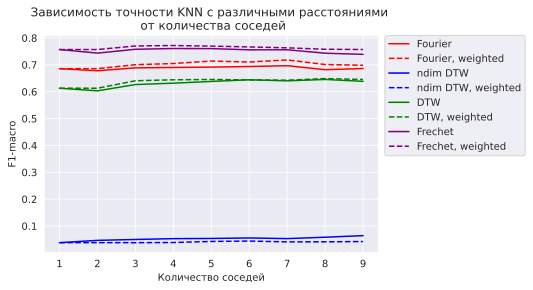

In [24]:
plt.plot(n_neighbors_list, fourier_uniform[0], c='r', label="Fourier")
plt.plot(n_neighbors_list, fourier_distance[0], c='r', label="Fourier, weighted", linestyle='dashed')
plt.plot(n_neighbors_list, dtw_ndim_uniform[0], c='b', label="ndim DTW")
plt.plot(n_neighbors_list, dtw_ndim_distance[0], c='b', label="ndim DTW, weighted", linestyle='dashed')
plt.plot(n_neighbors_list, dtw_uniform[0], c='green', label="DTW")
plt.plot(n_neighbors_list, dtw_distance[0], c='green', label="DTW, weighted", linestyle='dashed')
plt.plot(n_neighbors_list, frechet_uniform[0], c='purple', label="Frechet")
plt.plot(n_neighbors_list, frechet_distance[0], c='purple', label="Frechet, weighted", linestyle='dashed')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.xlabel("Количество соседей")
plt.ylabel("F1-macro")
plt.title("Зависимость точности KNN с различными расстояниями \n от количества соседей")
plt.show()

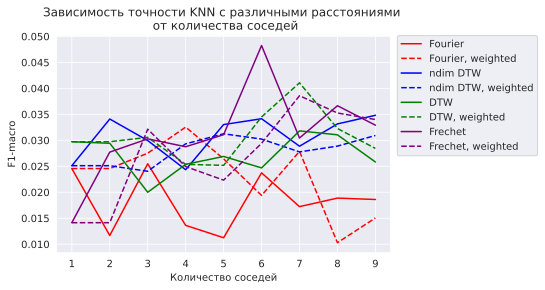

In [26]:
plt.plot(n_neighbors_list, fourier_uniform[1], c='r', label="Fourier")
plt.plot(n_neighbors_list, fourier_distance[1], c='r', label="Fourier, weighted", linestyle='dashed')
plt.plot(n_neighbors_list, dtw_ndim_uniform[1], c='b', label="ndim DTW")
plt.plot(n_neighbors_list, dtw_ndim_distance[1], c='b', label="ndim DTW, weighted", linestyle='dashed')
plt.plot(n_neighbors_list, dtw_uniform[1], c='green', label="DTW")
plt.plot(n_neighbors_list, dtw_distance[1], c='green', label="DTW, weighted", linestyle='dashed')
plt.plot(n_neighbors_list, frechet_uniform[1], c='purple', label="Frechet")
plt.plot(n_neighbors_list, frechet_distance[1], c='purple', label="Frechet, weighted", linestyle='dashed')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.xlabel("Количество соседей")
plt.ylabel("F1-macro")
plt.title("Зависимость точности KNN с различными расстояниями \n от количества соседей")
plt.show()